### calculate the SA signal for each order

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii, fits
from matplotlib.gridspec import GridSpec
from scipy import interpolate
from astropy.visualization import MinMaxInterval, AsinhStretch, HistEqStretch, ImageNormalize
from scipy.optimize import curve_fit
%matplotlib inline
#%matplotlib ipympl

In [2]:
# define the input/output parameters
source = 'DRTau_PA90'
path = '../191008/'            # path to the directory containing the proc and cal files
rectfile = source+'_combined'  # combined rectified file for all observations of source
calfile = 'wavecal1-28'        # associated wavecal file

In [3]:
# load atmospheric transmission file
hdu = fits.open('/Users/jpw/idl/Spextool/data/atran75000.fits')
tdata = hdu[0].data
atrans = interpolate.interp1d(tdata[0,:], tdata[1,:])
hdu.close()

In [4]:
hdu1 = fits.open(path+'proc/'+rectfile+'.fits')
flux = hdu1[0].data
var = hdu1[1].data
rect_hd = hdu1[0].header
#flux_norm = ImageNormalize(flux, interval=MinMaxInterval(), stretch=HistEqStretch(flux))
flux_norm = ImageNormalize(flux, vmin=-5, vmax=5, stretch=AsinhStretch(0.3))
nslit, nwl = flux.shape
flux_fit = np.zeros(flux.shape) + np.nan

hdu2 = fits.open(path+'cal/'+calfile+'.fits')
wc_hd = hdu2[0].header
orders = wc_hd['ORDERS'].split(',')
norders = wc_hd['NORDERS']

In [5]:
j1 = 30           # starting point of first order -- figured out by hand
dj_AB = 121       # width of each order -- this should match the size of the number of rows in the order extension
dj_blank = 30     # gap between orders -- this is figured out by eye and assumed to be the same for all orders

In [6]:
# two gaussians with different peaks and offsets but same FWHM
# added an extra constant offset since some orders are not perfectly sky-subtracted
def gauss2(x, A1, x1, A2, x2, sigma, C):
    y = A1 * np.exp(-0.5*((x-x1)/sigma)**2) + A2 * np.exp(-0.5*((x-x2)/sigma)**2) + C
    return y

In [7]:
def checkfit(pfit, perr, pfit_median, verbose=False):
    # check a few heuristics to see if this is a reasonable fit
    A1 = -pfit[0]
    x1 = pfit[1]
    A2 = pfit[2]
    x2 = pfit[3]
    sig = pfit[4]
    ok = True
    if (np.abs(A1-A2)/(A1+A2) > 0.2):
        if verbose: print('*** Positive and negative amplitudes are too different')
        ok = False
    if perr[1] > 0.05:
        if verbose: print('*** Error in negative position is too large')
        ok = False
    if perr[3] > 0.05:
        if verbose: print('*** Error in positive position is too large')
        ok = False
    if (perr[4] > 0.1*pfit_median[4]):
        if verbose: print('*** Error in sigma is too large')
        ok = False
    if (np.abs(x1-pfit_median[1]) > 1):
        if verbose: print('*** Negative position is too different from median')
        ok = False
    if (np.abs(x2-pfit_median[3]) > 1):
        if verbose: print('*** Positive position is too different from median')
        ok = False
    return ok

In [8]:
def fit_median(order_flux, s, s_nofit=0, plotfile=None):
    # stack an order in wavelength to measure the average slit profile and guide individual fits
    im_median = np.nanmedian(order_flux, axis=1)
    p0 = [np.min(im_median), s[np.argmin(im_median)], np.max(im_median), s[np.argmax(im_median)], 0.2, 0]

    # don't fit within s_nofit of the edges
    fit_range = (s > s_nofit) & (s < s.max()-s_nofit)

    # fit two gaussians to the data
    xfit = s[fit_range]
    pfit, pcov = curve_fit(gauss2, xfit, im_median[fit_range], p0)
    perr = np.sqrt(np.diag(pcov))

    if plotfile is not None:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.step(s, im_median)
        ax.plot(xfit, gauss2(xfit, *pfit))
        ax.set_xlabel(r"Slit position ('')", fontsize=14)
        ax.set_ylabel(r"Flux (Jy)", fontsize=14)
        fig.tight_layout()
        fig.savefig(plotfile, dpi=300)

    return pfit

In [9]:
def fit_all_columns(order_flux, s, s_nofit=0, verbose=False):
    pfit_median = fit_median(order_flux, s, s_nofit=s_nofit)#, plotfile='median_profile.png')
    fit_range = (s > s_nofit) & (s < s.max()-s_nofit)
    xfit = s[fit_range]

    nwl = order_flux.shape[1]
    pfit = np.zeros((6, nwl)) + np.nan
    perr = np.zeros((6, nwl)) + np.nan

    for n in range(nwl):
        flux_slice = order_flux[:, n]
        weights = 1 / order_var[:, n]
        p0 = [np.min(flux_slice), pfit_median[1], np.max(flux_slice), pfit_median[3], pfit_median[4], 0]
        try:
            pfit1, pcov1 = curve_fit(gauss2, xfit, flux_slice[fit_range], p0)
            perr1 = np.sqrt(np.diag(pcov1))
            if checkfit(pfit1, perr1, pfit_median, verbose=verbose):
                pfit[:, n] = pfit1
                perr[:, n] = perr1
            else:
                if verbose: print(wl[n])
        except RuntimeError:
            pass
        except ValueError:
            pass

    return pfit, perr

In [10]:
# loop through all orders and fit the profile for each wavelength, writing results to a csv file
csvfile = open(source+'_SA.csv', 'w')
for norder, order in enumerate(orders):
    j0 = j1 + (dj_AB + dj_blank) * norder
    order_flux = flux[j0:j0+dj_AB, :]
    order_var = var[j0:j0+dj_AB, :]

    wavecal = hdu2[3+norder].data
    wl0 = wavecal[0, 0, 1:]
    # pad the wavelength file for order 99 where the order cuts off before the end
    wl = np.pad(wl0, (0, nwl-wl0.size), 'edge')
    slitpos = wavecal[0, 1:, 0]
    print(f'Order = {order}, Min/Max wavelength = {wl.min()}, {wl.max()}')

    # set to True to get a lot of verbiage on fitting errors
    verbose = False
    pfit, perr = fit_all_columns(order_flux, slitpos, s_nofit=0.5, verbose=verbose)

    # populate an array with spectroastrometry information
    SA  = np.zeros((4, nwl)) + np.nan
    SA[0, :] = pfit[1, :]
    SA[1, :] = pfit[3, :]
    SA[2, :] = perr[1, :]
    SA[3, :] = perr[3, :]

    # flag out below a given atmospheric transmission
    flag = atrans(wl) < 0.5
    SA[:, flag] = np.nan

    for i in range(wl.size):
        csvfile.write(f'{wl[i]:11.9f}, {SA[0, i]:7.4f}, {SA[1, i]:7.4f}, {SA[2, i]:7.4f}, {SA[3, i]:7.4f}\n')

    # calculate the model fit
    imfit = np.zeros(order_flux.shape)
    for i in range(nwl):
        pfit1 = pfit[:, i]
        if not np.isnan(np.sum(pfit1)):
            imfit[:, i] = gauss2(slitpos, *pfit1)
    flux_fit[j0:j0+dj_AB, :] = imfit

    # plot the results if you want
    plot = False
    if plot:
        extent = [wl.min(), wl.max(), slitpos.min(), slitpos.max()]
        fig = plt.figure(figsize=(7, 12))
        ax1 = fig.add_subplot(311)
        ax1.imshow(order_flux, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
        ax2 = fig.add_subplot(312)
        ax2.imshow(imfit, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
        ax3 = fig.add_subplot(313)
        ax3.imshow(order_flux-imfit, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
        ax3.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
        ax3.set_ylabel(r"Slit offset ('')", fontsize=12)
        fig.tight_layout()
        fig.savefig(source+'_order'+order+'_fit.png', dpi=300)

csvfile.close()

Order = 99, Min/Max wavelength = 5.1899714963290755, 5.233661102706405


/Users/jpw/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Order = 100, Min/Max wavelength = 5.138258380184553, 5.182081500846873
Order = 101, Min/Max wavelength = 5.0875455965731575, 5.130879358693153
Order = 102, Min/Max wavelength = 5.037827021053397, 5.0806852506971545
Order = 103, Min/Max wavelength = 4.989073696092097, 5.031469816624533
Order = 104, Min/Max wavelength = 4.941257777907975, 4.9832048254813435
Order = 105, Min/Max wavelength = 4.894352483435795, 4.935863121740658
Order = 106, Min/Max wavelength = 4.84833204029257, 4.889418574612957
Order = 107, Min/Max wavelength = 4.80317163954939, 4.84384603016119
Order = 108, Min/Max wavelength = 4.758847391127053, 4.7991212660760905
Order = 109, Min/Max wavelength = 4.715336281646959, 4.755220948940934
Order = 110, Min/Max wavelength = 4.672616134581073, 4.712122593827319
Order = 111, Min/Max wavelength = 4.630665572555934, 4.669804526074945
Order = 112, Min/Max wavelength = 4.5894639816760865, 4.628245845118916
Order = 113, Min/Max wavelength = 4.548991477741863, 4.587426390237711
Orde

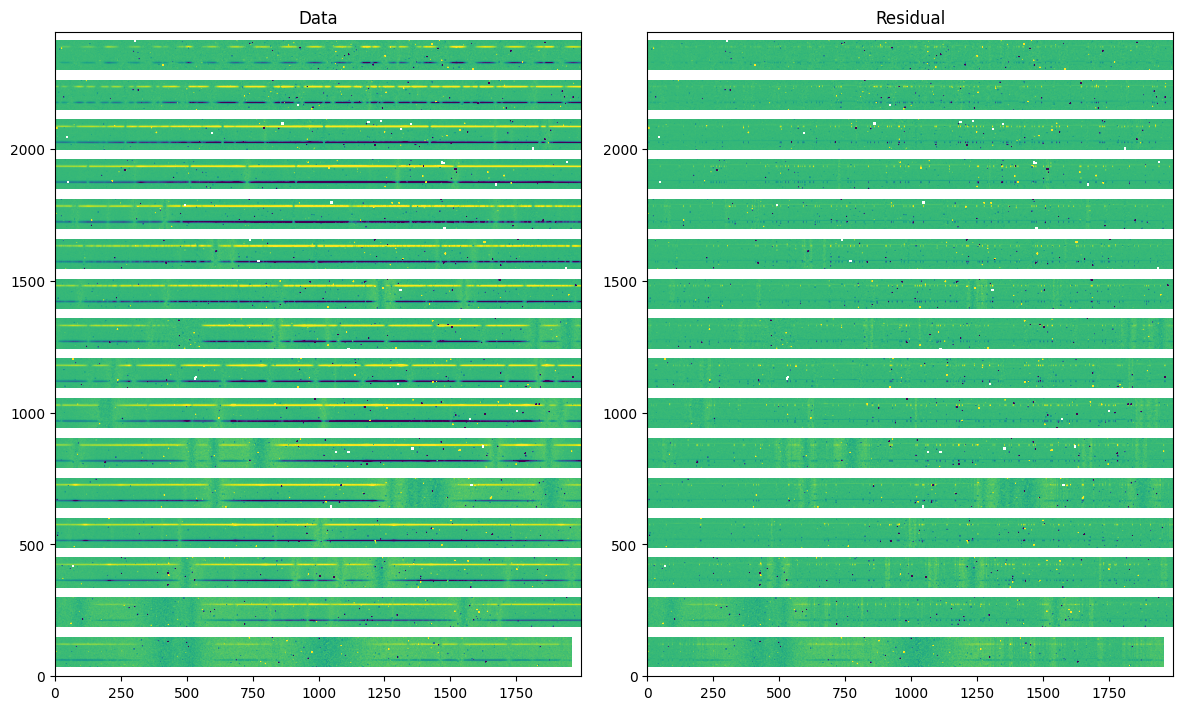

In [11]:
# compare the data and model
fig = plt.figure(figsize=(12, 7))
ax1 = plt.subplot(121)
ax1.imshow(flux, origin='lower', norm=flux_norm)
ax1.set_title('Data')
ax2 = plt.subplot(122)
ax2.imshow(flux - flux_fit, origin='lower', norm=flux_norm)
ax2.set_title('Residual')

fig.tight_layout()
fig.savefig(source+'_fit.png', dpi=300)

Text(0, 0.5, "Slit position ('')")

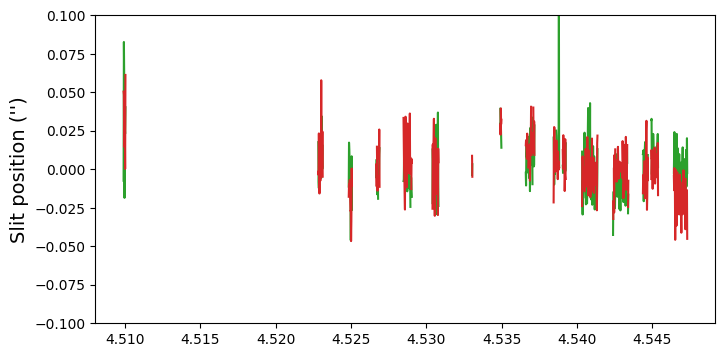

In [12]:
# plot the SA signal
fig, ax = plt.subplots(figsize=(8, 4))

# absolute positions on the slit
ax.plot(wl, SA[0, :])
ax.plot(wl, SA[1, :])
ax.set_ylim(0,15)

# take away their median to show overlap
SA[0, :] -= np.nanmedian(SA[0, :])
SA[1, :] -= np.nanmedian(SA[1, :])
ax.plot(wl, SA[0, :])
ax.plot(wl, SA[1, :])
ax.set_ylim(-0.1, 0.1)
ax.set_ylabel(r"$\lambda$ ($\mu$m)", fontsize=14)
ax.set_ylabel(r"Slit position ('')", fontsize=14)

Text(0, 0.5, "Slit position ('')")

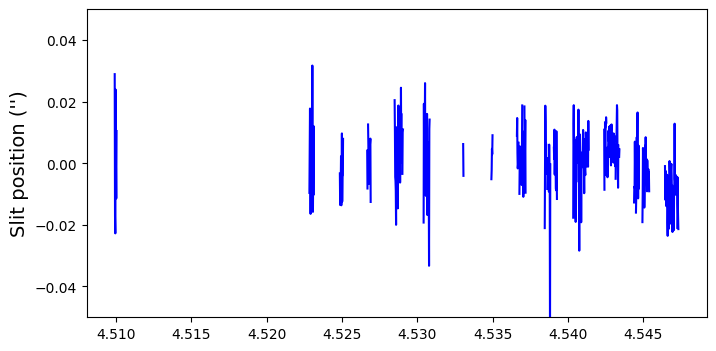

In [13]:
# plot the combined SA signal
SA_comb = 0.5 * (SA[1, :] - SA[0, :])
SA_comb_err = 0.5 * np.sqrt(SA[3, :]**2 + SA[2, :]**2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(wl, SA_comb, color='b')
#ax.errorbar(wl, SA_comb, yerr=SA_comb_err, color='b', ecolor='r', barsabove=True)
ax.set_ylim(-0.05,0.05)
ax.set_ylabel(r"$\lambda$ ($\mu$m)", fontsize=14)
ax.set_ylabel(r"Slit position ('')", fontsize=14)
